In [1]:
import LCAnalyses as LCA
import importlib
import matplotlib.pyplot as plt
import numpy as np
import random as rd
importlib.reload(LCA)

<module 'LCAnalyses' from 'c:\\Users\\Yong Hee Lee\\Downloads\\temp\\Summerschool\\LCAnalyses.py'>

## Generate LC

In [2]:
def Generate_dates(coverage=365*6, cadence=50):
    dates = np.linspace(0, coverage, coverage//cadence)
    dates = dates + np.random.random_sample(len(dates))*cadence-cadence/2
    dates -= dates[0]
    return dates

def Generate_fluxes(dates, ini=3, prior="null", seed=int(rd.random()*1000000), para=0):
    # prior must be "null", "sine", or "linear".
    fluxes = np.ones(len(dates))*ini
    #rd.seed(seed)
    #np.random.seed(seed)
    fluxes = fluxes + np.random.normal(0, 0.02*fluxes[0], len(dates))

    if rd.random() < 1e-4:
        fluxes[rd.randint(0, len(dates))] += rd.random()*10
    

    if prior == "sine":
        amp = rd.uniform(0, 0.5)*ini
        phase = rd.uniform(0, 2*np.pi)
        freq = 1/rd.uniform((dates[-1]-dates[0])*6, (dates[-1]-dates[0])*40)
        if para:
            amp, freq = para[0], para[1]
        fluxes = fluxes + amp*np.sin(2*np.pi*freq*dates+phase)
        return fluxes, amp, freq, phase
    elif prior == "linear":
        slope = rd.uniform(-0.5/dates[-1]*ini, 0.5/dates[-1]*ini)
        fluxes = fluxes + slope*dates-np.mean(slope*dates)
    return fluxes

In [87]:
class Freeze:
    i = 0
    def __init__(self, dates, fluxes):
        self.sources = {}
        self.sources["ID"] = i
        self.sources["dates"] = dates
        self.sources["fluxes"] = fluxes
        i += 1

Text(0, 0.5, 'Flux')

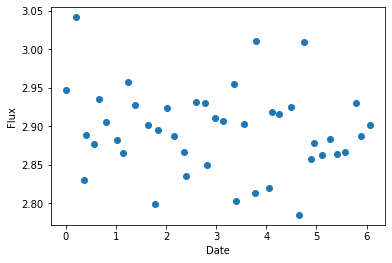

In [9]:
dates = Generate_dates()/365

#draw = rd.random()
#if draw < 0.2:
#    prior = "sine"
ini=3

fluxes, amp, freq, phase = Generate_fluxes(dates, ini=ini, prior="sine")
#fluxes = Generate_fluxes(dates, prior="linear")
plt.scatter(dates, fluxes)
plt.xlabel('Date')
plt.ylabel('Flux')

(0.0, 1.0)

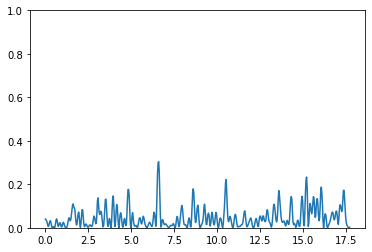

In [11]:
fid_err = 0.02*np.mean(fluxes)

ls_source = LCA.LCLombscargle(dates, fluxes, fid_err)
FAP_Sin = ls_source.FAPs[np.where(ls_source.powers == np.max(ls_source.powers))][0]
#dates_center = (min(dates) + max(dates))/2
plt.plot(ls_source.freqs, ls_source.powers)
#plt.xlim([0, 2])
plt.ylim([0, 1])

### Find the best-fit sinusoid

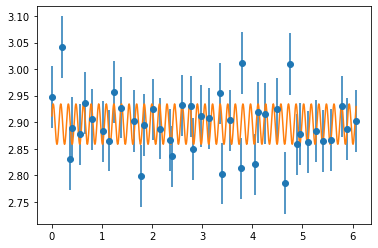

In [12]:
chi2_Null = np.sum((fluxes-np.mean(fluxes))**2/fid_err**2)
xplotter = np.linspace(0, dates[-1], 1000)

modelpar = ls_source.modelpara()
sinfit = ls_source.mulsin(dates, modelpar)
chi2_Sin = np.sum(abs(np.array(fluxes)-sinfit)**2/fid_err**2)

# plotter =========================
plt.errorbar(dates, fluxes, [fid_err for x in dates], fmt='o')
plt.plot(xplotter, ls_source.mulsin(xplotter, modelpar), c="C1")

### Find the best_fit linear function

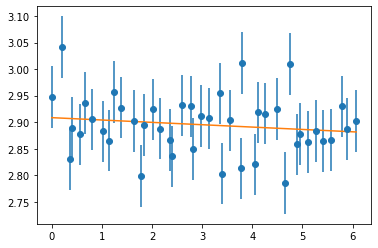

In [13]:
sol_para, sol_err = LCA.LCLinearfit(dates, fluxes, [fid_err for x in fluxes])
slope = sol_para[0]
dslope = sol_err[0]

linfit = np.array(dates)*sol_para[0] + sol_para[1]
chi2_Lin = np.sum(((fluxes)-linfit)**2)/fid_err**2
Pow_Lin = (chi2_Null-chi2_Lin)/chi2_Null
FAP_Lin = (1-Pow_Lin)**((len(dates)-2)/2)


# Plotter =======================
plt.errorbar(dates, fluxes, [fid_err for x in dates], fmt='o')
plt.plot(xplotter, xplotter*sol_para[0] + sol_para[1], color="C1")


### Calculate FAP

In [14]:
Power_Sin = np.max(ls_source.powers)
FAP_Sin_single = ls_source.FAP_single
Baluev_FAP = ls_source.FAP_peak
dfreq = ls_source.freqs[1]-ls_source.freqs[0]
num_freqs = modelpar[1]//dfreq+1
FAP_mod = FAP_Sin_single*num_freqs

print("Baluev FAP : {}".format(Baluev_FAP[0]))
print("Single FAP : {}".format(FAP_Sin_single))
print("Modified FAP : {}".format(FAP_mod))
print("Linear FAP : {}".format(FAP_Lin))

Baluev FAP : 0.21133081952238902
Single FAP : 0.0007125866140868567
Modified FAP : 0.14322990943145822
Linear FAP : 0.6450811114882115
